In [93]:
# https://www.kaggle.com/vijaykumar1799/face-mask-detection

# The Goal for this project is to develop a model that predicts
# whether a given picture is one of no mask, mask, or mask worn incorrectly.

# The model is an adaptation of that portrayed in this notebook:
# https://www.kaggle.com/brsdincer/mask-prediction-process-end-to-end

# Imports. Version numbers in development are shown in comments; higher versions should work as well.

import tensorflow as tf # Version 2.4.0-rc0
import cv2 # 4.5.1
import matplotlib.pyplot as plt # Matplotlib version 3.4.2.
import pandas as pd # 1.3.0
import os
import numpy as np # 1.21.0
import sklearn # 0.24.2
from sklearn.metrics import confusion_matrix # For some reason the call sklearn.metrics.confusion_matrix doesn't work
# so importing that directly.
import seaborn # 0.11.1

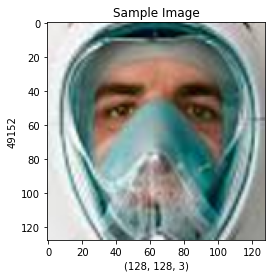

In [2]:
# An example of reading in and displaying an image

filename = "./Dataset/with_mask/1.png"
img = cv2.imread(filename)
# The flag cv2.COLOR_BGR2RGB is necessary because OpenCV and the way these PNG files are stored have different
# conventions for the ordering of colors.
Transformation_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.xlabel(Transformation_RGB.shape)
plt.ylabel(Transformation_RGB.size)
plt.title("Sample Image")

plt.imshow(Transformation_RGB)

In [3]:
# Put the image data (filenames and labels) into a pandas dataframe.
folders = ["with_mask","without_mask","mask_weared_incorrect"]
filenames = np.array([["./Dataset/"+folders[i]+"/"+str(j)+".png",folders[i]] for i in range(3) for j in range(3001)])
filenames = np.array([filenames[i] for i in range(len(filenames)) if os.path.exists(filenames[i][0])])
filenames = np.reshape(filenames,(filenames.shape[0],filenames.shape[1]))
img_df = pd.DataFrame(
    filenames,
    columns=['Filename', 'Label']
)

In [4]:
# Set up training, testing, and validation sets
# See https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
# 80% test, 10% training, 10% validation

# The validation set is used to decide when to apply early stopping.
# Without early stopping, there is a risk of overfitting, where model parameters are tuned
# to noise in the training set that is not generalizable to the test set.
# Because the validation set is used multiple times, a third set, the test set, is needed to prevent
# overfitting to the training set.
img_df = img_df.sample(frac=1).reset_index(drop=True)

train_size = int(len(img_df)*0.8)
test_size = int(( len(img_df) - train_size )/2)
validation_size = len(img_df) - train_size-test_size

train_df = img_df[:train_size]
test_df = img_df[train_size:train_size+test_size]
validation_df = img_df[train_size+test_size:]

# Load images
# In the notebook used to model this code, some transformations are performed to
# augment the training data. We are not doing that here.
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_IMG_Set = img_generator.flow_from_dataframe(dataframe=train_df,
                                                       x_col="Filename",
                                                       y_col="Label",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       subset="training")

validation_IMG_Set = img_generator.flow_from_dataframe(dataframe=validation_df,
                                                       x_col="Filename",
                                                       y_col="Label",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128)
                                                    )

test_IMG_Set = img_generator.flow_from_dataframe(dataframe=test_df,
                                                       x_col="Filename",
                                                       y_col="Label",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       shuffle=False)

Found 7185 validated image filenames belonging to 3 classes.
Found 899 validated image filenames belonging to 3 classes.
Found 898 validated image filenames belonging to 3 classes.


In [6]:
# A sequential model is appropriate for a plain stack of layers where 
# every layer has one input tensor and one output tensor.
# See https://keras.io/guides/sequential_model/
Model = tf.keras.models.Sequential()

# Conv2D is a 2D convolution layer
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# relu (Rectified Linear Unit) is a commonly used activation function.
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU
Model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(128,128,3)))
# Batch normalization sets the mean and variance of a layer to near 0 and 1 respectively.
# It helps with the exploding gradient problem.
# See https://keras.io/api/layers/normalization_layers/batch_normalization/
Model.add(tf.keras.layers.BatchNormalization())
# Take the maximum size feature over a window.
# See https://keras.io/api/layers/pooling_layers/max_pooling2d/
# This helps improve translation invariance.
# See https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
Model.add(tf.keras.layers.MaxPooling2D((2,2)))

Model.add(tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"))
# Dropout probabilistically drops out some nodes.
# This regularization technique helps reduce overfitting.
# See https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.MaxPooling2D((2,2)))

Model.add(tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.MaxPooling2D((2,2)))

Model.add(tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.MaxPooling2D((2,2)))

# Flattening reduces the tensor to one dimension
Model.add(tf.keras.layers.Flatten())
# A fully connected neural network layer.
# https://keras.io/api/layers/core_layers/dense/
Model.add(tf.keras.layers.Dense(256,activation="relu"))
Model.add(tf.keras.layers.Dropout(0.5))

# A final layer which outputs which of the three classes (mask, no mark, mask worn incorrectly) the image is.
# The softmax activiation function converts the numbers into probabilities, which are the network's estimation
# of the probabilities of each of the three classes.
# They satisfy the expected properties that probabilities are nonnegative and sum to 1.
Model.add(tf.keras.layers.Dense(3,activation="softmax"))

# Early stopping is done to prevent training the network too long and getting overfitting.
# If the network trains for 'patience' epochs with no improvement to the loss function, then training is cut off
# See https://keras.io/api/callbacks/early_stopping/
Early_Stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [7]:
# The optimization function governs how parameters are updated.
# 'adam' is a commonly used method.
# See https://ruder.io/optimizing-gradient-descent/

# Categorical cross entropy is a common loss function in multiclass classification problems, like this one.
# See https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy
Model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [7]:
CNN_Sep_Model = Model.fit(train_IMG_Set,validation_data=validation_IMG_Set,callbacks=Early_Stop,epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-20 12:03:18.805451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-20 12:03:18.805583: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


225/225 [==============================] - ETA: 0s - loss: 2.6889 - accuracy: 0.7402WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2e29f8310> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
225/225 [==============================] - 36s 157ms/step - loss: 2.6954 - accuracy: 0.7403 - val_loss: 0.6565 - val_accuracy: 0.7620
Ep

In [8]:
# Save the model
Model.save("main_model.h5")
Model.save_weights("main_model_weight.h5")

In [13]:
# Load the model if desired. If has been trained once, this avoids the time of training again.
# It was necessary for me to downgrade h5py to make this work. In the terminal, run
# pip install 'h5py==2.10.0' --force-reinstall
# If the plotting functions below are desired, then the model must be retrained.
Model.load_weights("main_model_weight.h5")

In [12]:
Grap_Data = pd.DataFrame(CNN_Sep_Model.history)
figure = plt.figure(figsize=(10,10))

Grap_Data.plot()

# This network should show early stopping after about 5-10 epochs or so and the validation loss gets worse.

AttributeError: 'NoneType' object has no attribute 'history'

No handles with labels found to put in legend.


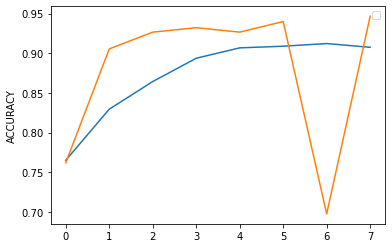

In [10]:
plt.plot(CNN_Sep_Model.history["accuracy"])
plt.plot(CNN_Sep_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()


No handles with labels found to put in legend.


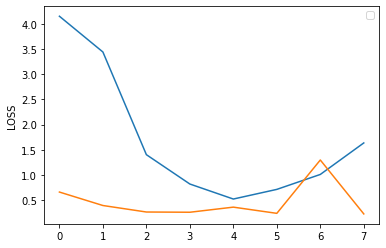

In [11]:
plt.plot(CNN_Sep_Model.history["loss"])
plt.plot(CNN_Sep_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.show()

In [15]:
Model_Results = Model.evaluate(test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

# Accuracy on the test set is ideally in the 90's of percent.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 1s 43ms/step - loss: 0.1566 - accuracy: 0.9433
LOSS:  0.1602
ACCURACY:  0.9488


[[257  15   2]
 [ 10 316   6]
 [  8   5 279]]


<AxesSubplot:>

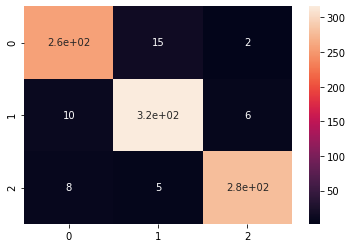

In [101]:
# Confusion matrix.
# See https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

predicted = Model.predict(test_IMG_Set)
predicted = [np.argmax(t[i]) for i in range(len(t))]
cm = sklearn.metrics.confusion_matrix(t, test_IMG_Set.labels)
print(cm) # Raw numbers
seaborn.heatmap(cm, annot=True) # As a heatmap. The off-diagonal entries should be close to black.

In [90]:
# Display the names of labels and the numbers as in the test set. This will show the correspondence between
# images and labels.
# So, for instance, if the first number in test_IMG_Set.labels is 2 and the first label in test_df["Label"],
# is 'without_mask', this shows that 'without_mask' corresponds to item 2 in the confusion matrix.
# If 10 items are not enough to represent all three labels, then increase the number as necessary.
print(test_IMG_Set.labels[:10])
test_df["Label"][:10]

[2, 1, 2, 0, 0, 2, 0, 1, 0, 1]


7185             without_mask
7186                with_mask
7187             without_mask
7188    mask_weared_incorrect
7189    mask_weared_incorrect
7190             without_mask
7191    mask_weared_incorrect
7192                with_mask
7193    mask_weared_incorrect
7194                with_mask
Name: Label, dtype: object